# Squeeze dispersion in the Samoan Passage

## Introduction

In this notebook we calculate diffusivity (κ) from profiles of turbulent dissipation (ε) and 
potential density referenced to 4,000 meters depth (σ) observed in the Samoan Passage
by Alford, Carter, Girton and Voet. We define the density variable ρ via:

ρ = σ + 1000.

Our procedure is:

1. Sort σ in z to obtain a stable density profile. We permute ε by the same vector that sorts σ, so that the relationship between turbulent dissipation and σ remains the same, while it is the association between σ and height z that changes.
2. Performing a moving average of both σ and ε over some depth d.
3. Discretize density space into a small number of layers, and use trapezoidal integration to calculate the layer-integrated turbulent dissipation.
4. Calculate κ_local = Γε/N^2 = Γε * (-g Δρ / ρ0 Δζ), where Δρ is the width of the layer in density space, and Δζ is the vertical separation betwen the edges of the layer.
5. Define an integral over the Samoan passage transect, using the distance along the transect as the spatial coordinate.
6. Calculate the average buoyancy flux <Γε> and the thickness weighted buoyancy gradient <1/N^2> = -ρ0 <Δζ> / Δρ g.
7. Calculate the effective diffusivity across the layer with κ_eff = <Γε><1/N^2>.

## Initialization

Below, we initialize the pacakages we need and add two new functions, `compileoverturns` and `toradians`, to the workspace.

In [90]:
using Pkg
Pkg.activate("..")

using Printf, Statistics,
        JLD2, FileIO, Interpolations, PyCall, PyPlot, PyPlotPlus, DataStructures,
        SqueezeDispersion.Samoan

@pyimport matplotlib.colors as clrs

using LinearAlgebra: norm

usecmbright() # for plotting

function compileoverturns(vmp; davg=nothing)

    overturns = Dict{Symbol,Array{Float64,1}}()
       overturns[:z] = Array{Float64,1}()
     overturns[:sig] = Array{Float64,1}()
      overturns[:dz] = Array{Float64,1}()
    overturns[:dsig] = Array{Float64,1}()

    for name in keys(vmp)
        z, ep, sig = unpack_vmp_profile(vmp[name])
        
        if davg != nothing
            sig = movingavg(sig, davg)
        end
        
        z_ov, sig_ov, z_delta, sig_delta = getoverturns(z, sig)
        
        append!(overturns[:z], z_ov)
        append!(overturns[:sig], sig_ov)    
        append!(overturns[:dz], z_delta) 
        append!(overturns[:dsig], sig_delta)
    end
    
    overturns
end

toradians(x...) = (π/180 * y for y in x)

function trapz(x, f)
    kernel = @views @. (f[2:end] + f[1:end-1]) * (x[2:end] - x[1:end-1])
    return 0.5*sum(kernel)
end

function enmesh(yedges, x, fx)
    # Start up
    y = @views @. 0.5*(yedges[2:end] + yedges[1:end-1])
    fx_itp = interpolate((fx,), x, Gridded(Linear()))
    fy = similar(y)
    
    for i = 1:length(ycells)
        # Find data within cell
        left = yedges[i]
        right = yedges[i+1]
        ii = left .<= x .<= right
        
        # Construct array of data within cell, using linear 
        # interpolation to find endpoints
        xcell = cat([left], x[ii], [right], dims=1)
        fcell = cat([fx_itp(left)], fx[ii], [fx_itp(right)], dims=1)
        
        # Compute cell-average of data.
        fy[i] = trapz(xcell, fcell) / (right - left)
    end
    
    y, fy
end

enmesh (generic function with 1 method)

## Load and manipulate data

Below we load the CTD and VMP data. To facilitate the creation of an 'along-track' axis, we order the VMP data by latitude. Because the Samoan passage is nearly oriented north-south, we then calculate along-track distance as the cumulative distance between each station.

In [51]:
datapath = joinpath("..", "data", "samoanpassagedata.jld2")
ctd = load(datapath, "ctd")
vmp = load(datapath, "vmp")

# Sort vmp data from south to north
vmpbylat = OrderedDict{Float64,Any}()
for (name, profile) in vmp
    profile["name"] = name
    vmpbylat[profile["lat"]] = profile
end

sort!(vmpbylat)
vmp = OrderedDict{String,Any}()
for profile in values(vmpbylat)
    vmp[profile["name"]] = profile
end

ctdlon = ctd["lon"]
ctdlat = ctd["lat"]
ctdsigma = ctd["sigma4"]
ctddepth = ctd["depth"]

nz, nctd = size(ctdsigma)
nvmp = length(vmp)
println("CTD data size: ndepth = $nz, nctd = $nctd, nvmp = $nvmp\n")

firstprofile = "SP1_Line9_02"
lat0 = vmp[firstprofile]["lat"]
lon0 = vmp[firstprofile]["lon"]
dist0 = 0.0

println("VMP profiles:\n")
for (i, profile) in enumerate(values(vmp))
    z, ep, sig = unpack_vmp_profile(profile)  
    
    lat = profile["lat"]
    lon = profile["lon"]
    
    # Calculate along-track coordinate
    lat1, lon1, lat2, lon2 = toradians(lat0, lon0, lat, lon)
    profile["distance"] = latlondist(lat1, lon1, lat2, lon2) + dist0
    
    @printf("% 13s (%.2f N, %.2f W) | x: % 7.2f km, z: (%d, %d) meters, σ₄: (%.5f, %.5f) kg/m³\n", 
        profile["name"], lat, lon, profile["distance"]*1e-3, z[1], z[end], 
        nanmaximum(sig), nanminimum(sig))
    
    dist0 = profile["distance"]
    lat0 = lat
    lon0 = lon  
end

CTD data size: ndepth = 6001, nctd = 18, nvmp = 13

VMP profiles:

 SP1_Line9_02 (-9.83 N, -169.31 W) | x:    0.00 km, z: (-5303, -3442) meters, σ₄: (45.97834, 45.85083) kg/m³
 SP1_Line9_04 (-9.48 N, -169.02 W) | x:   49.88 km, z: (-5234, -3442) meters, σ₄: (45.97827, 45.85180) kg/m³
 SP1_Line9_06 (-9.14 N, -168.98 W) | x:   87.49 km, z: (-5122, -3442) meters, σ₄: (45.97770, 45.85166) kg/m³
 SP1_Line9_07 (-9.04 N, -168.96 W) | x:   98.79 km, z: (-4962, -3442) meters, σ₄: (45.97797, 45.85172) kg/m³
 SP1_Line9_08 (-8.99 N, -168.96 W) | x:  104.78 km, z: (-4691, -3442) meters, σ₄: (45.97777, 45.84898) kg/m³
 SP1_Line9_09 (-8.90 N, -168.90 W) | x:  116.72 km, z: (-4990, -3442) meters, σ₄: (45.97545, 45.84830) kg/m³
SP1_Line9_102 (-8.81 N, -168.76 W) | x:  134.50 km, z: (-4977, -3442) meters, σ₄: (45.97648, 45.84982) kg/m³
SP1_Line9_112 (-8.61 N, -168.73 W) | x:  156.14 km, z: (-5079, -3442) meters, σ₄: (45.97665, 45.85238) kg/m³
 SP1_Line9_13 (-8.31 N, -168.66 W) | x:  190.29 km, z: (-5052

## Visualize data

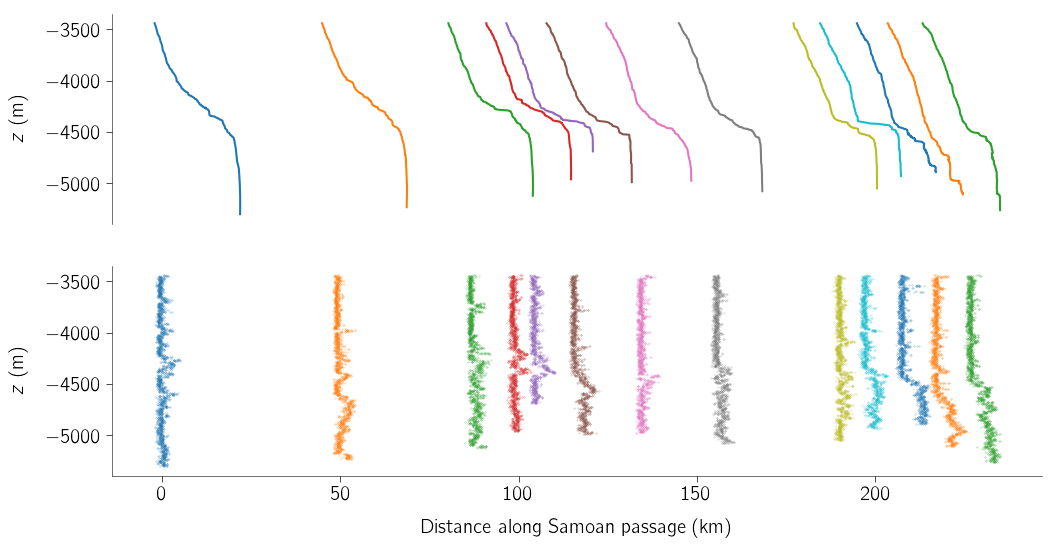

In [53]:
fig, axs = subplots(nrows=2, figsize=(12, 6))

sca(axs[1])
sidespine()
axs[1][:tick_params](bottom=false, labelbottom=false)
ylabel(L"z \, \, \mathrm{(m)}", labelpad=12.0)


sca(axs[2])
cornerspines()
xlabel("Distance along Samoan passage (km)"; labelpad=12.0)
ylabel(L"z \, \, \mathrm{(m)}", labelpad=12.0)

m_ep = 2e3 # [ep]/[distance]
m_sig = 2e8

for (i, profile) in enumerate(values(vmp))
    z, ep, sig = unpack_vmp_profile(profile)
    
    ep_filtered = filter(x->x>0 && isfinite(x), ep)
    offset_ep = nanmean(log.(10, ep_filtered))
    offset_sig = nanminimum(sig)
    gtz = ep .> 0
     
    # Visualize density profile and dissipation along the track.
    sca(axs[1])
    plot(1e-3*(m_sig.*(sig.-offset_sig)) .+ profile["distance"], z, "-")
    
    sca(axs[2])
    plot(1e-3*(m_ep.*(log.(10, ep[gtz]).-offset_ep) .+ profile["distance"]), z[gtz], ".", linewidth=1, markersize=0.5, alpha=0.6)
    
end

## Grid data in density space

In [ ]:
d = 0
for (i, profile) in enumerate(values(vmp))
    z, ep, sig = unpack_vmp_profile(profile)
    
    sig_sorted, ep_sorted = simulsort(sig, ep)
    
    if d > 0
        sig_sorted = movingavg(sig_sorted, davg=d)
        ep_sorted = movingavg(ep_sorted, davg=d)
    end

    
end